In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
display(HTML("<style>.output_result { max-width:90% !important; }</style>"))

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import PIL
import tensorflow as tf

# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

# if tf.test.gpu_device_name():
#     print('GPU found')
# else:
#     print("No GPU found")

# # No GPU found


from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.models import Sequential, Model
from keras.layers import Flatten, Dense, Dropout, BatchNormalization

from keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions

from tensorflow.keras.callbacks import ModelCheckpoint

from tabulate import tabulate

titles_str = os.listdir('dataset/train/')
num_classes = len(titles_str)

# **Loading dataset**

In [3]:
batch_size = 32
img_height = 224
img_width = 224

# from google.colab import drive
# drive.mount('/content/gdrive')

## Mount Google drive

In [4]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [5]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
#     'gdrive/MyDrive/Peltarion v1/dataset/train/Image', 
    'dataset/train',
    label_mode='categorical', color_mode='rgb', 
    batch_size=32, image_size=(224, 224), seed=42, validation_split=0.2, subset="training"
)


val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
#     'gdrive/MyDrive/Peltarion v1/dataset/validation/Image', 
    'dataset/train',
    label_mode='categorical', color_mode='rgb', 
    batch_size=32, image_size=(224, 224), seed=42, validation_split=0.2, subset="validation"
)

Found 2992 files belonging to 7 classes.
Using 2394 files for training.
Found 2992 files belonging to 7 classes.
Using 598 files for validation.


## Show the data

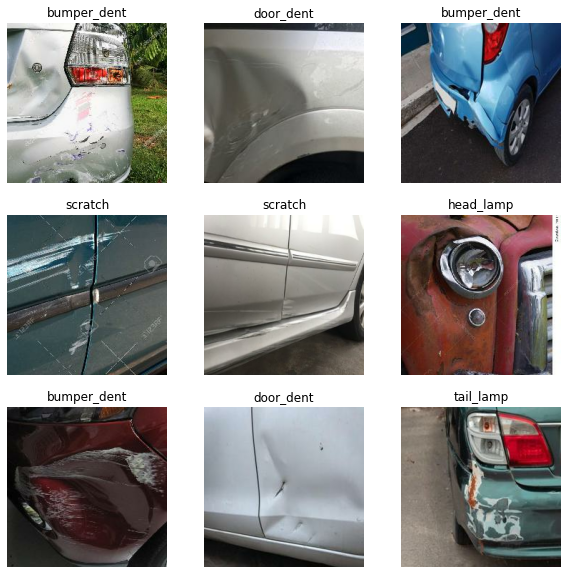

In [6]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  
  titles = tf.argmax(labels, axis=1).numpy().tolist()

  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(titles_str[titles[i]])
    plt.axis("off")

## Resize, rescale and augment functions

In [7]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

IMG_SIZE = 224

resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
  # layers.experimental.preprocessing.Rescaling(1./255)
])

## Augment the dataset, preprocess and optimization functions

In [8]:
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):

  # Resize and rescale all datasets
  ds = ds.map(lambda x, y: (resize_and_rescale(x), y), num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000)

  # Batch all datasets
  # ds = ds.batch(batch_size)

  # Use data augmentation only on the training set
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)
  
  # preprocess for VGG16
  ds = ds.map(lambda x, y: (preprocess_input(x), y), 
              num_parallel_calls=AUTOTUNE)

  # Use buffered prefecting on all datasets
  return ds.prefetch(buffer_size=AUTOTUNE)

train_dataset = prepare(train_dataset, shuffle=True, augment=True)
val_dataset = prepare(val_dataset)

# **Model definition**

## Model architecture

In [9]:
num_classes = len(titles_str)

resnet = ResNet50(include_top=False)

for layer in resnet.layers:
	layer.trainable = False

model = Sequential([
    resnet,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.1),
    layers.Flatten(),
    layers.BatchNormalization(),
    layers.Dense(1024, activation='relu'),
#     layers.Dropout(0.1),
    layers.Dense(num_classes)
])

# model.summary()

In [10]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, None, None, 2048)  23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192      
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dense_1 (Dense)              (None, 7)                

## Checkpoint

In [11]:
filepath = 'model/best_model.epoch{epoch:02d}-accuracy{val_accuracy:.5f}.hdf5'

checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_accuracy',
                             verbose=1, 
                             save_best_only=True,
                             mode='max')

callbacks = [checkpoint]

# callbacks = []

## Compile and train

In [12]:
num_classes = len(titles_str)
history_dict = {}
dropout_controller = np.arange(0.5,0.9,0.1)

for dropout in dropout_controller:
    display(HTML(f"<h1>Dropout: {dropout}</h1>"))
    resnet = ResNet50(include_top=False)

    for layer in resnet.layers:
        layer.trainable = False

    model = tf.keras.models.Sequential([
        resnet,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dropout(dropout),
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(1024, activation='relu'),
    #     layers.Dropout(0.1),
        tf.keras.layers.Dense(num_classes, activation='sigmoid')
    ])

    model.compile(optimizer='adam',
                  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy'])

    # model.summary()
    epochs = 50
    history = model.fit(
      train_dataset,
      validation_data=val_dataset,
      epochs=epochs,
      callbacks=callbacks
    )
    
    
    history_dict[dropout] = history
    print()
    print()
    print()

Epoch 1/20
75/75 [==============================] - 26s 179ms/step - loss: 1.4898 - accuracy: 0.6103 - val_loss: 1.0723 - val_accuracy: 0.7023

Epoch 00001: val_accuracy improved from -inf to 0.70234, saving model to model\best_model.epoch01-accuracy0.70234.hdf5


c:\users\user\anaconda3\envs\tf2\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/20
75/75 [==============================] - 14s 147ms/step - loss: 0.8332 - accuracy: 0.7561 - val_loss: 0.9245 - val_accuracy: 0.7224

Epoch 00002: val_accuracy improved from 0.70234 to 0.72241, saving model to model\best_model.epoch02-accuracy0.72241.hdf5
Epoch 3/20
75/75 [==============================] - 16s 162ms/step - loss: 0.6768 - accuracy: 0.7836 - val_loss: 0.7946 - val_accuracy: 0.7709

Epoch 00003: val_accuracy improved from 0.72241 to 0.77090, saving model to model\best_model.epoch03-accuracy0.77090.hdf5
Epoch 4/20
75/75 [==============================] - 16s 154ms/step - loss: 0.5442 - accuracy: 0.8204 - val_loss: 0.7848 - val_accuracy: 0.7609

Epoch 00004: val_accuracy did not improve from 0.77090
Epoch 5/20
75/75 [==============================] - 16s 153ms/step - loss: 0.4837 - accuracy: 0.8346 - val_loss: 0.7940 - val_accuracy: 0.7676

Epoch 00005: val_accuracy did not improve from 0.77090
Epoch 6/20
75/75 [==============================] - 15s 154ms/step - l

Epoch 1/20
75/75 [==============================] - 20s 170ms/step - loss: 1.4754 - accuracy: 0.6069 - val_loss: 1.0018 - val_accuracy: 0.6789

Epoch 00001: val_accuracy did not improve from 0.78428
Epoch 2/20
75/75 [==============================] - 18s 169ms/step - loss: 0.9737 - accuracy: 0.7268 - val_loss: 0.7922 - val_accuracy: 0.7441

Epoch 00002: val_accuracy did not improve from 0.78428
Epoch 3/20
75/75 [==============================] - 16s 159ms/step - loss: 0.7265 - accuracy: 0.7769 - val_loss: 0.7841 - val_accuracy: 0.7609

Epoch 00003: val_accuracy did not improve from 0.78428
Epoch 4/20
75/75 [==============================] - 17s 171ms/step - loss: 0.6459 - accuracy: 0.7957 - val_loss: 0.8138 - val_accuracy: 0.7592

Epoch 00004: val_accuracy did not improve from 0.78428
Epoch 5/20
75/75 [==============================] - 17s 162ms/step - loss: 0.5888 - accuracy: 0.8049 - val_loss: 0.8046 - val_accuracy: 0.7826

Epoch 00005: val_accuracy did not improve from 0.78428
Epoch

Epoch 1/20
75/75 [==============================] - 21s 175ms/step - loss: 1.5148 - accuracy: 0.5873 - val_loss: 0.9993 - val_accuracy: 0.7090

Epoch 00001: val_accuracy did not improve from 0.78595
Epoch 2/20
75/75 [==============================] - 16s 158ms/step - loss: 1.0673 - accuracy: 0.6967 - val_loss: 0.8766 - val_accuracy: 0.7575

Epoch 00002: val_accuracy did not improve from 0.78595
Epoch 3/20
75/75 [==============================] - 16s 158ms/step - loss: 0.8402 - accuracy: 0.7352 - val_loss: 0.9130 - val_accuracy: 0.7425

Epoch 00003: val_accuracy did not improve from 0.78595
Epoch 4/20
75/75 [==============================] - 16s 158ms/step - loss: 0.7390 - accuracy: 0.7619 - val_loss: 0.9112 - val_accuracy: 0.7375

Epoch 00004: val_accuracy did not improve from 0.78595
Epoch 5/20
75/75 [==============================] - 16s 162ms/step - loss: 0.6704 - accuracy: 0.7757 - val_loss: 0.9880 - val_accuracy: 0.7258

Epoch 00005: val_accuracy did not improve from 0.78595
Epoch

Epoch 1/20
75/75 [==============================] - 21s 174ms/step - loss: 1.4736 - accuracy: 0.5894 - val_loss: 0.9301 - val_accuracy: 0.7174

Epoch 00001: val_accuracy did not improve from 0.79933
Epoch 2/20
75/75 [==============================] - 16s 158ms/step - loss: 1.1644 - accuracy: 0.6683 - val_loss: 0.7746 - val_accuracy: 0.7692

Epoch 00002: val_accuracy did not improve from 0.79933
Epoch 3/20
75/75 [==============================] - 16s 156ms/step - loss: 0.9755 - accuracy: 0.6955 - val_loss: 0.7781 - val_accuracy: 0.7609

Epoch 00003: val_accuracy did not improve from 0.79933
Epoch 4/20
75/75 [==============================] - 16s 158ms/step - loss: 0.8309 - accuracy: 0.7297 - val_loss: 0.7722 - val_accuracy: 0.7625

Epoch 00004: val_accuracy did not improve from 0.79933
Epoch 5/20
75/75 [==============================] - 16s 160ms/step - loss: 0.7484 - accuracy: 0.7456 - val_loss: 0.7203 - val_accuracy: 0.7642

Epoch 00005: val_accuracy did not improve from 0.79933
Epoch

Epoch 1/20
75/75 [==============================] - 21s 173ms/step - loss: 1.5497 - accuracy: 0.5526 - val_loss: 0.9090 - val_accuracy: 0.7475

Epoch 00001: val_accuracy did not improve from 0.79933
Epoch 2/20
75/75 [==============================] - 16s 159ms/step - loss: 1.2477 - accuracy: 0.6491 - val_loss: 0.8830 - val_accuracy: 0.7207

Epoch 00002: val_accuracy did not improve from 0.79933
Epoch 3/20
75/75 [==============================] - 16s 159ms/step - loss: 1.0900 - accuracy: 0.6654 - val_loss: 0.7933 - val_accuracy: 0.7458

Epoch 00003: val_accuracy did not improve from 0.79933
Epoch 4/20
75/75 [==============================] - 16s 160ms/step - loss: 1.0190 - accuracy: 0.6679 - val_loss: 0.6994 - val_accuracy: 0.7525

Epoch 00004: val_accuracy did not improve from 0.79933
Epoch 5/20
75/75 [==============================] - 16s 155ms/step - loss: 0.8944 - accuracy: 0.6955 - val_loss: 0.6683 - val_accuracy: 0.7726

Epoch 00005: val_accuracy did not improve from 0.79933
Epoch

Epoch 1/20
75/75 [==============================] - 21s 172ms/step - loss: 1.6459 - accuracy: 0.5192 - val_loss: 0.8658 - val_accuracy: 0.7174

Epoch 00001: val_accuracy did not improve from 0.80602
Epoch 2/20
75/75 [==============================] - 16s 161ms/step - loss: 1.4215 - accuracy: 0.5940 - val_loss: 0.8362 - val_accuracy: 0.7408

Epoch 00002: val_accuracy did not improve from 0.80602
Epoch 3/20
75/75 [==============================] - 17s 173ms/step - loss: 1.2177 - accuracy: 0.6278 - val_loss: 0.7115 - val_accuracy: 0.7492

Epoch 00003: val_accuracy did not improve from 0.80602
Epoch 4/20
75/75 [==============================] - 16s 161ms/step - loss: 1.1734 - accuracy: 0.6224 - val_loss: 0.6378 - val_accuracy: 0.7742

Epoch 00004: val_accuracy did not improve from 0.80602
Epoch 5/20
75/75 [==============================] - 16s 159ms/step - loss: 0.9911 - accuracy: 0.6633 - val_loss: 0.6863 - val_accuracy: 0.7625

Epoch 00005: val_accuracy did not improve from 0.80602
Epoch

Epoch 1/20
75/75 [==============================] - 21s 169ms/step - loss: 1.7176 - accuracy: 0.4808 - val_loss: 0.9044 - val_accuracy: 0.7124

Epoch 00001: val_accuracy did not improve from 0.80602
Epoch 2/20
75/75 [==============================] - 16s 160ms/step - loss: 1.5592 - accuracy: 0.5468 - val_loss: 0.8614 - val_accuracy: 0.7124

Epoch 00002: val_accuracy did not improve from 0.80602
Epoch 3/20
75/75 [==============================] - 16s 156ms/step - loss: 1.3767 - accuracy: 0.5781 - val_loss: 0.7845 - val_accuracy: 0.7090

Epoch 00003: val_accuracy did not improve from 0.80602
Epoch 4/20
75/75 [==============================] - 16s 159ms/step - loss: 1.2554 - accuracy: 0.5915 - val_loss: 0.7370 - val_accuracy: 0.7341

Epoch 00004: val_accuracy did not improve from 0.80602
Epoch 5/20
75/75 [==============================] - 16s 159ms/step - loss: 1.1234 - accuracy: 0.6053 - val_loss: 0.7104 - val_accuracy: 0.7508

Epoch 00005: val_accuracy did not improve from 0.80602
Epoch

Epoch 1/20
75/75 [==============================] - 21s 171ms/step - loss: 1.8874 - accuracy: 0.4119 - val_loss: 0.7878 - val_accuracy: 0.7375

Epoch 00001: val_accuracy did not improve from 0.80602
Epoch 2/20
75/75 [==============================] - 16s 157ms/step - loss: 1.8313 - accuracy: 0.4808 - val_loss: 0.8316 - val_accuracy: 0.7107

Epoch 00002: val_accuracy did not improve from 0.80602
Epoch 3/20
75/75 [==============================] - 16s 159ms/step - loss: 1.6147 - accuracy: 0.5042 - val_loss: 0.7402 - val_accuracy: 0.7358

Epoch 00003: val_accuracy did not improve from 0.80602
Epoch 4/20
75/75 [==============================] - 16s 158ms/step - loss: 1.4612 - accuracy: 0.5084 - val_loss: 0.7304 - val_accuracy: 0.7458

Epoch 00004: val_accuracy did not improve from 0.80602
Epoch 5/20
75/75 [==============================] - 16s 157ms/step - loss: 1.3117 - accuracy: 0.5535 - val_loss: 0.7440 - val_accuracy: 0.7358

Epoch 00005: val_accuracy did not improve from 0.80602
Epoch

Epoch 1/20
75/75 [==============================] - 21s 170ms/step - loss: 2.3668 - accuracy: 0.2824 - val_loss: 0.9379 - val_accuracy: 0.6605

Epoch 00001: val_accuracy did not improve from 0.80602
Epoch 2/20
75/75 [==============================] - 16s 155ms/step - loss: 2.1783 - accuracy: 0.3513 - val_loss: 0.8707 - val_accuracy: 0.6973

Epoch 00002: val_accuracy did not improve from 0.80602
Epoch 3/20
75/75 [==============================] - 16s 161ms/step - loss: 1.9476 - accuracy: 0.3722 - val_loss: 0.9415 - val_accuracy: 0.6856

Epoch 00003: val_accuracy did not improve from 0.80602
Epoch 4/20
75/75 [==============================] - 16s 155ms/step - loss: 1.7854 - accuracy: 0.3743 - val_loss: 0.9765 - val_accuracy: 0.7241

Epoch 00004: val_accuracy did not improve from 0.80602
Epoch 5/20
75/75 [==============================] - 16s 154ms/step - loss: 1.6642 - accuracy: 0.3952 - val_loss: 1.0315 - val_accuracy: 0.6873

Epoch 00005: val_accuracy did not improve from 0.80602
Epoch

## Visualize training results

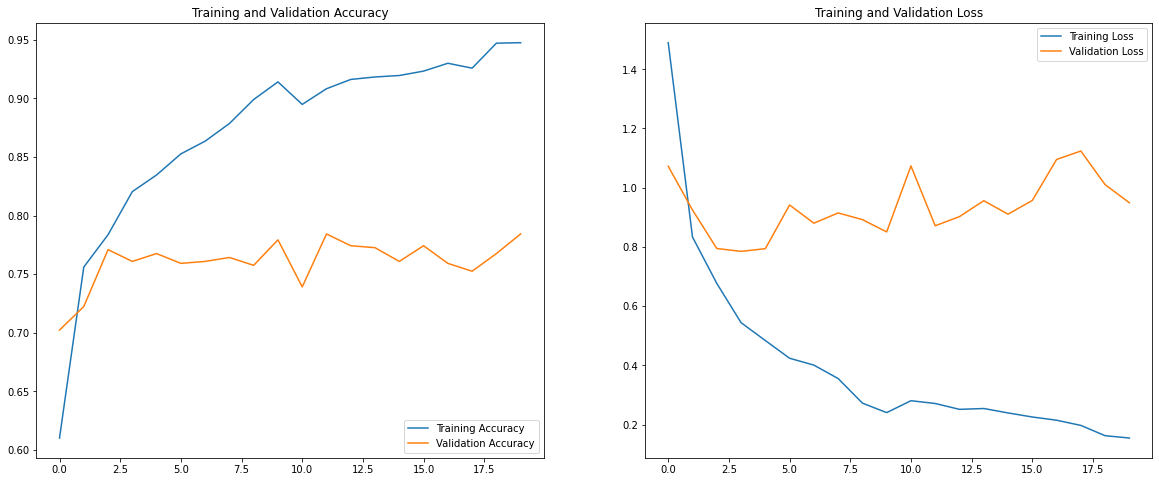

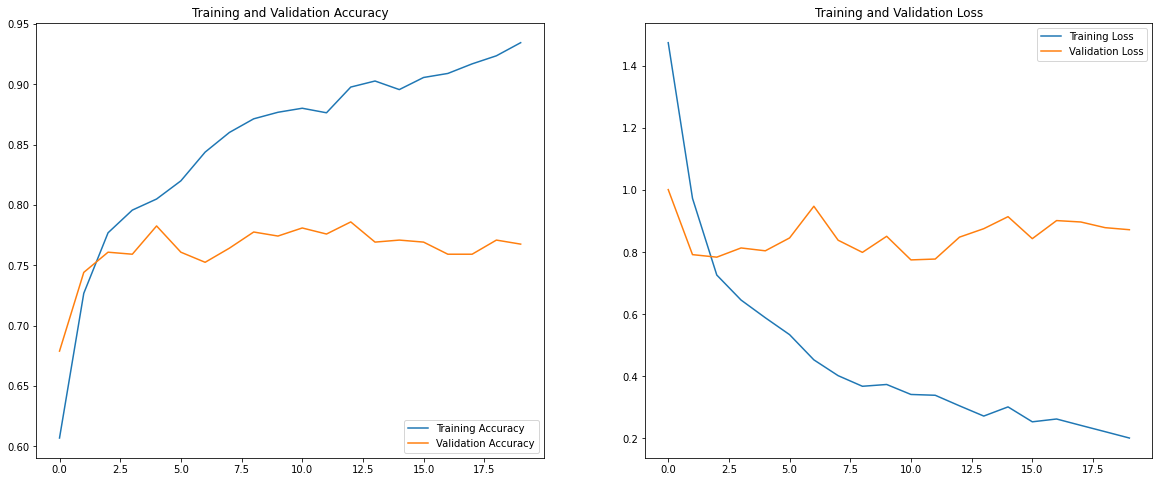

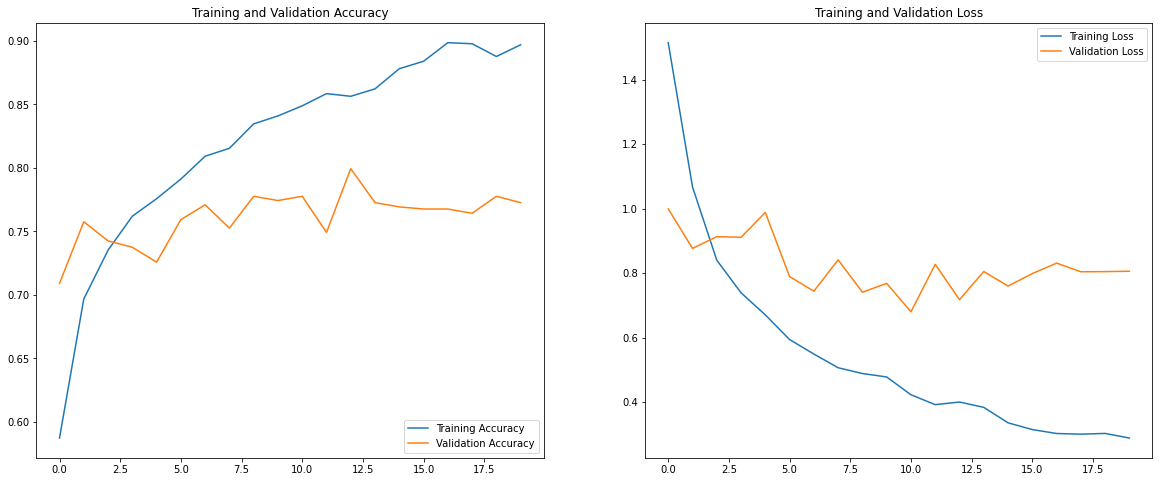

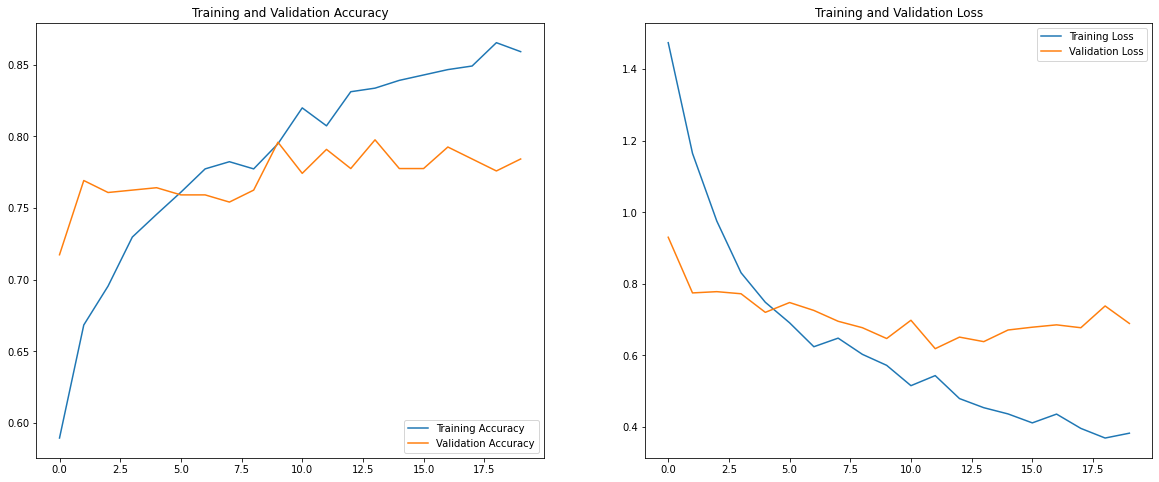

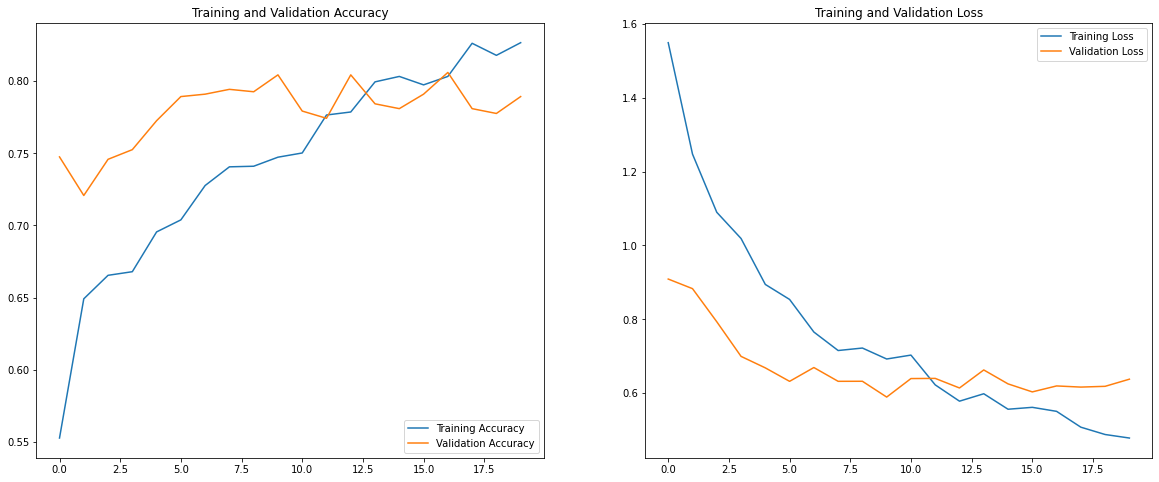

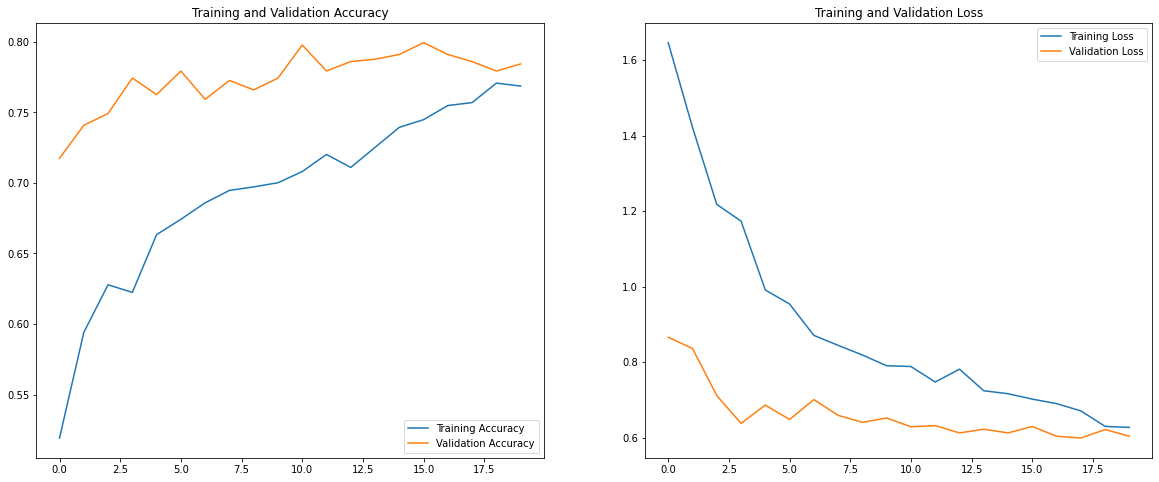

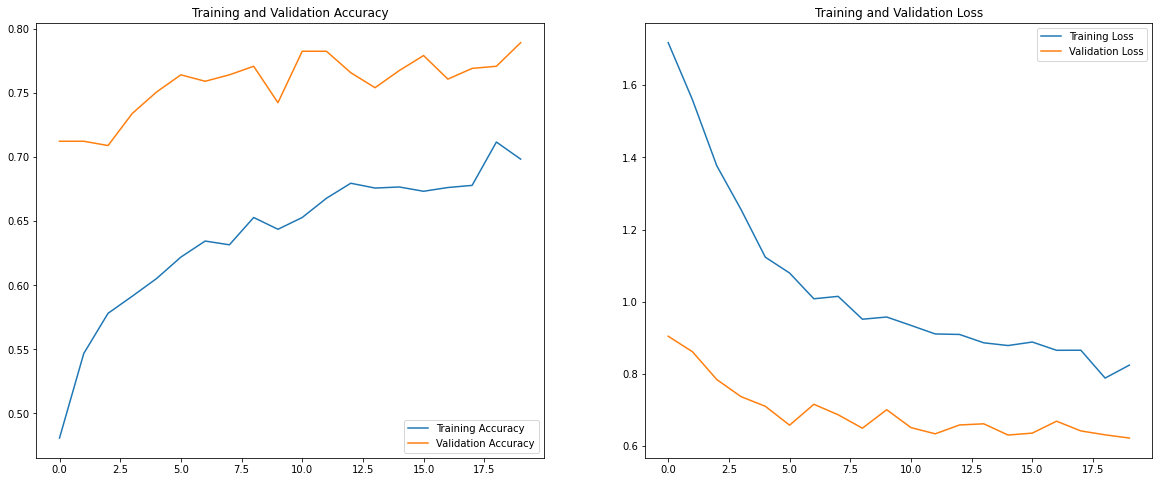

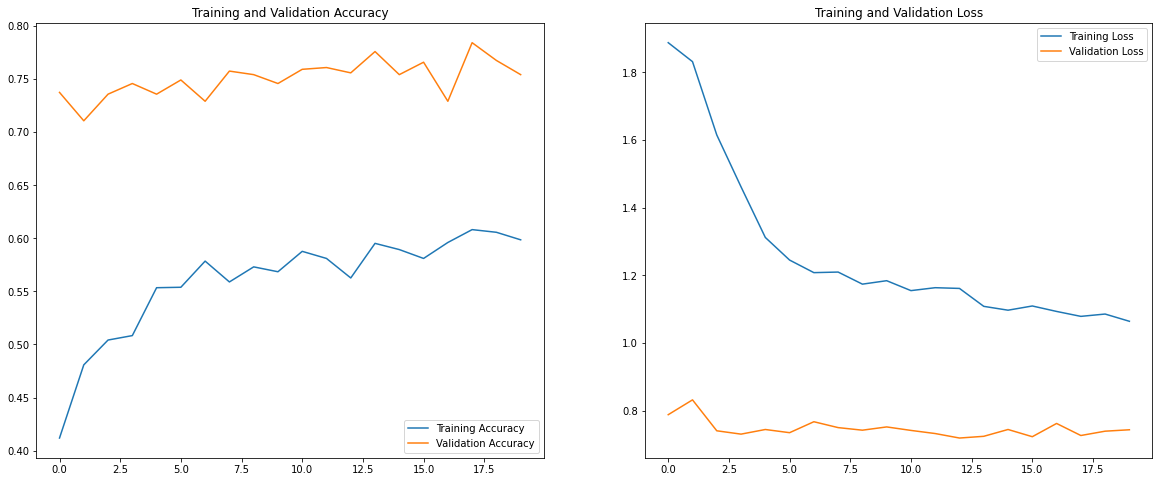

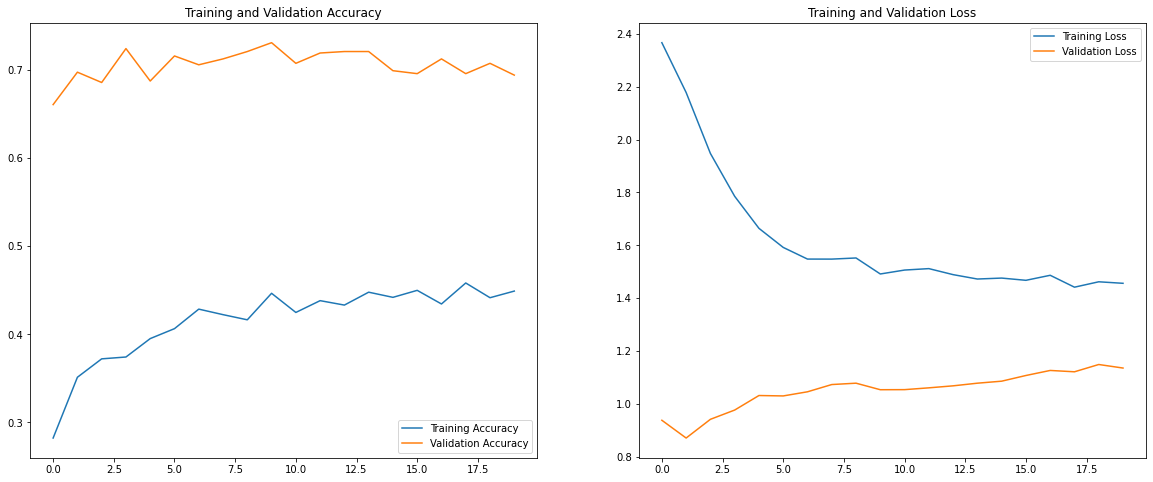

In [13]:
for dropout in dropout_controller:
    display(HTML(f"<h2>Dropout: {dropout}</h2>"))
    history = history_dict[dropout] # replace dropout with the value you want

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    # plt.style.use("dark_background")
    plt.figure(figsize=(20, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()
    print()
    print()

# **Identifying weakness of the model**

## Import best resnet50 model

In [16]:
from keras.models import load_model
model = load_model('model/best_model.epoch17-accuracy0.80602.hdf5')

## Tabulate results

In [20]:
grand_total = 0 # total number of images in the test set
grand_correct = 0 # total number of images in the test set classified correctly

table = [["class", "acc"]]
for cl in titles_str: # cl is the current class selected
    table[0].append(cl)

    row = []
    row.append(cl)

    # cl = 'door_scratch'

    temp_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    #     'gdrive/MyDrive/Peltarion v1/dataset/validation/Image', 
        'dataset/test/' + cl,
        label_mode='categorical', color_mode='rgb', 
        batch_size=32, image_size=(224, 224), seed=42
    )

    correct = titles_str.index(cl)
    predictions = tf.math.argmax(tf.nn.softmax(model.predict(temp_dataset)), axis=1).numpy()

    len_cl = len(predictions) # number of images in this class in the test set
    correct_predictions = np.count_nonzero(predictions == correct)
    grand_correct += correct_predictions
    grand_total += len_cl
    accuracy = round(correct_predictions/len_cl, 3)

    wrong_percentage = np.zeros(num_classes)

    for p in predictions:
        if p != correct:
            wrong_percentage[p] += 1

    wrong_percentage = wrong_percentage/len_cl
    wrong_percentage = np.around(wrong_percentage, 3) # round to 3 decimal places
    wrong_percentage = wrong_percentage.tolist()
    wrong_percentage[correct] = 'NA'

    for index, i in enumerate(wrong_percentage):
        if i == 0.0:
            wrong_percentage[index] = 0

    row.append(accuracy)

    for w in wrong_percentage:
        row.append(w)
        
    table.append(row)

Found 15 files belonging to 1 classes.
Found 18 files belonging to 1 classes.
Found 15 files belonging to 1 classes.
Found 15 files belonging to 1 classes.
Found 15 files belonging to 1 classes.
Found 15 files belonging to 1 classes.
Found 15 files belonging to 1 classes.


In [21]:
print("TEST SET RESULTS")
print("-----------------")
print(tabulate(table, headers="firstrow"))

print()
print("OVERALL ACCURACY: ", round(grand_correct/grand_total, 2))

TEST SET RESULTS
-----------------
class            acc  bumper_dent    door_dent    glass_shatter    head_lamp    no_damage    scratch    tail_lamp
-------------  -----  -------------  -----------  ---------------  -----------  -----------  ---------  -----------
bumper_dent    0.333  NA             0            0                0            0.6          0.067      0
door_dent      0.056  0.111          NA           0.056            0            0.5          0.278      0
glass_shatter  0.6    0              0.067        NA               0            0.2          0.133      0
head_lamp      0.133  0.133          0            0                NA           0.533        0.2        0
no_damage      0.867  0.067          0            0                0            NA           0.067      0
scratch        0.6    0              0            0                0            0.4          NA         0
tail_lamp      0      0.2            0            0                0            0.2          0.6   

In [22]:
print("Most common misclassifications")
print("===============================")
table2 = [["class", "acc", "wrong class", "wrong class %"]]
for row in table[1:]:
    r = []
    r.append(row[0])
    r.append(row[1])
    
    maximum = 0
    max_idx = 0
    for index, j in enumerate(row[2:]):
        if type(j)!=str:
            if j > maximum:
                maximum = j
                max_idx = index
    
    r.append(titles_str[max_idx])
    r.append(maximum)
    
    table2.append(r)

print(tabulate(table2, headers="firstrow"))

Most common misclassifications
class            acc  wrong class      wrong class %
-------------  -----  -------------  ---------------
bumper_dent    0.333  no_damage                0.6
door_dent      0.056  no_damage                0.5
glass_shatter  0.6    no_damage                0.2
head_lamp      0.133  no_damage                0.533
no_damage      0.867  bumper_dent              0.067
scratch        0.6    no_damage                0.4
tail_lamp      0      scratch                  0.6


## View misclassified images

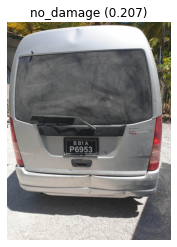

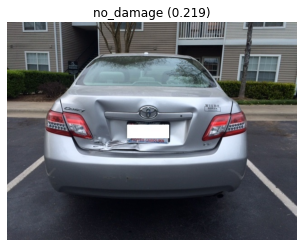

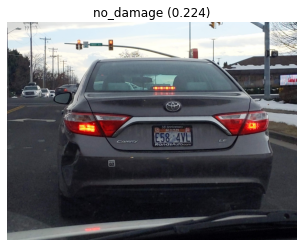

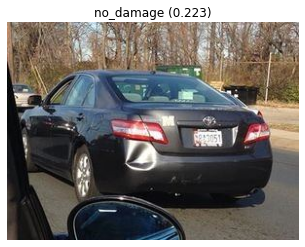

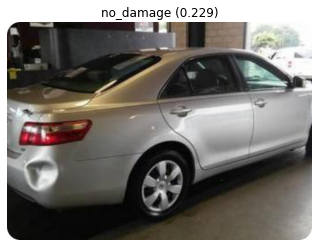

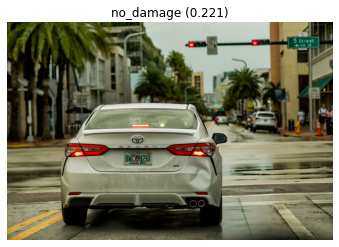

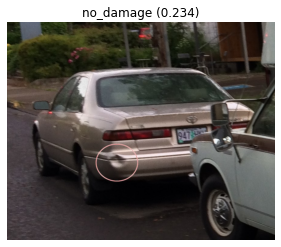

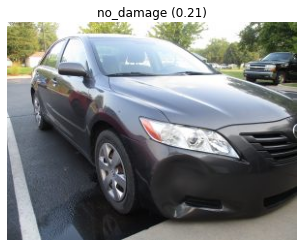

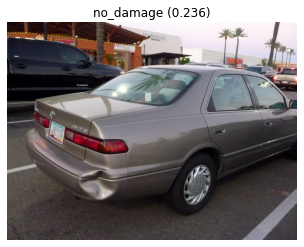

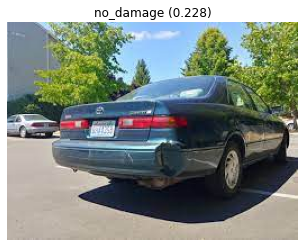

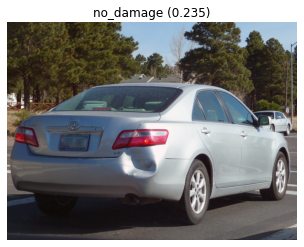

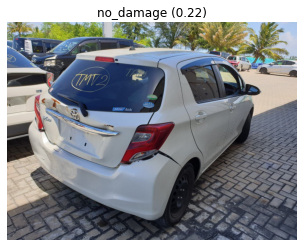

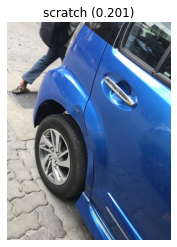

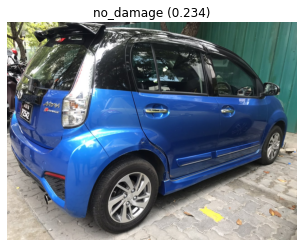

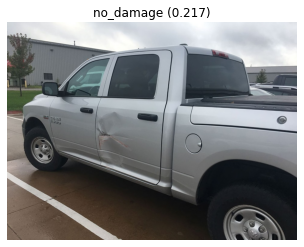

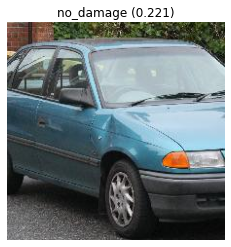

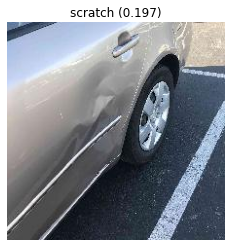

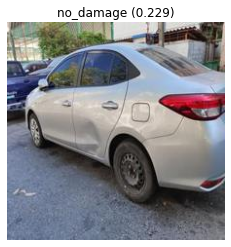

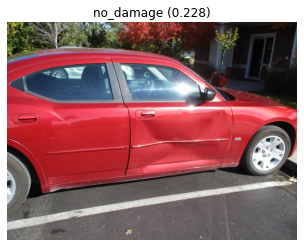

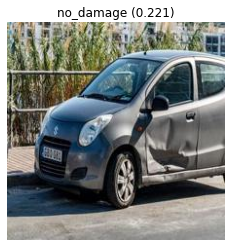

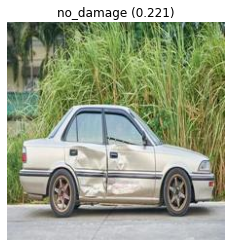

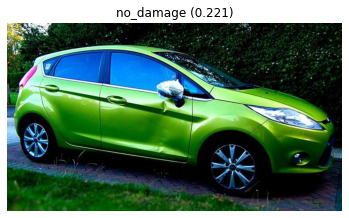

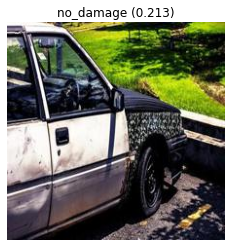

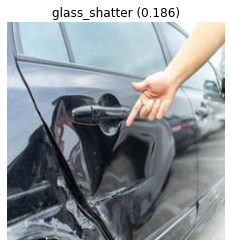

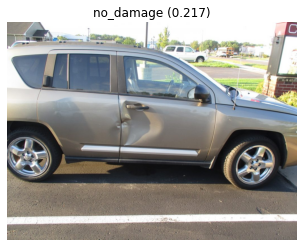

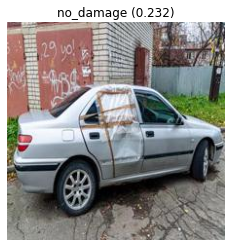

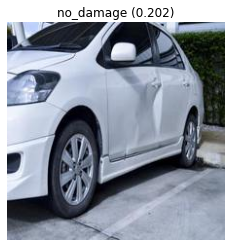

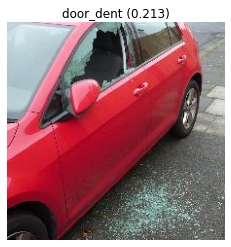

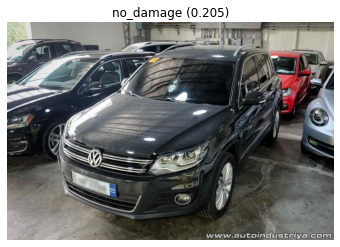

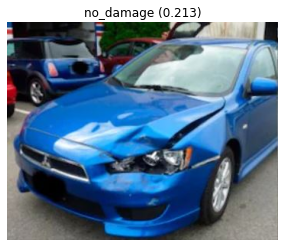

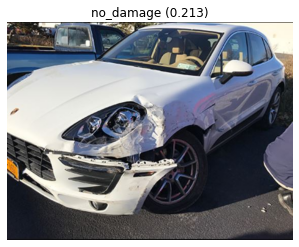

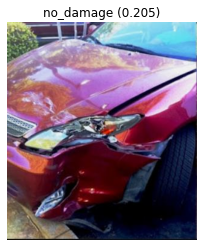

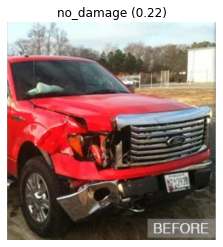

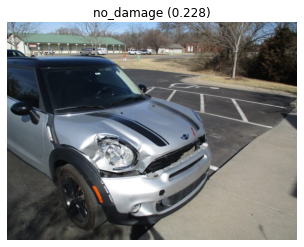

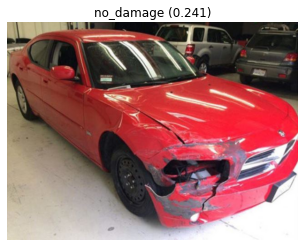

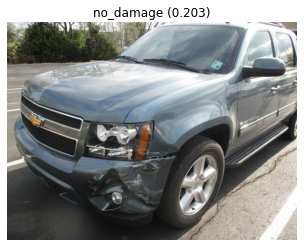

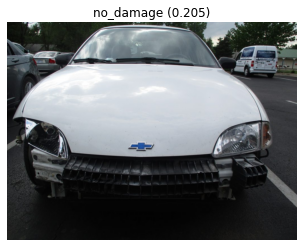

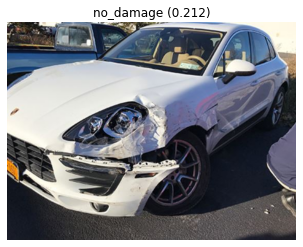

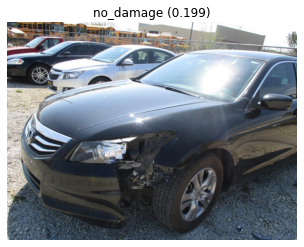

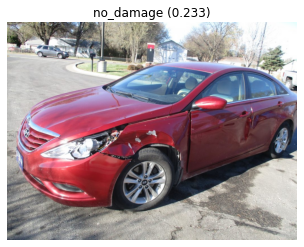

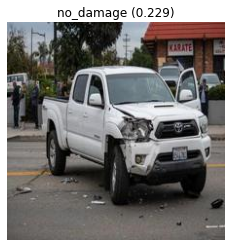

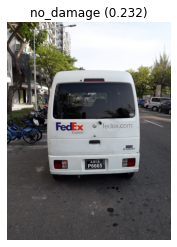

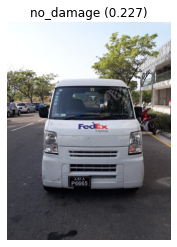

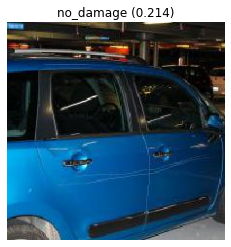

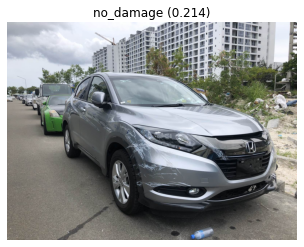

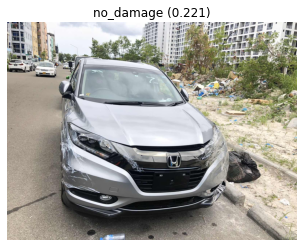

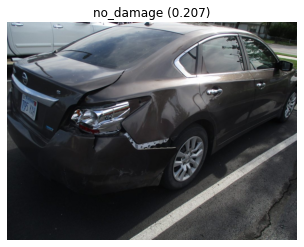

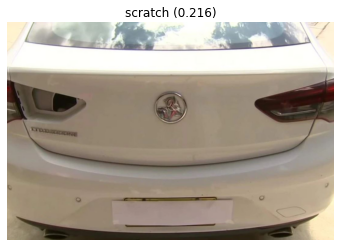

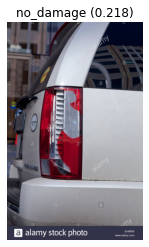

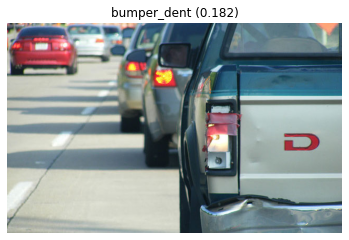

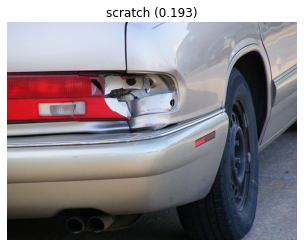

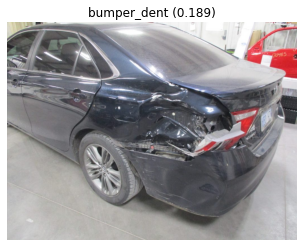

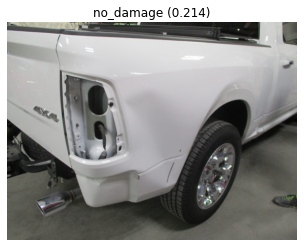

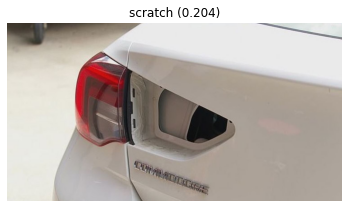

In [37]:
for cl in titles_str:
    display(HTML(f"<h1>Actual class: {cl}</h1>"))
    
    for picture in os.listdir(f"dataset/test/{cl}/Image"):
        correct_index = titles_str.index(cl) # actual index of correct class
        
        with PIL.Image.open(f"dataset/test/{cl}/Image/{picture}") as img:
            img_copy = img.copy() # non resized copy for display
            img_copy = img_copy.convert('RGB')
            img_copy = np.array(img_copy)
            
            img = img.resize((224, 224))
            img = img.convert('RGB')
            img = np.array(img)
        
        img = preprocess_input(img)
        img = np.expand_dims(img, axis=0) # create a batch of 1 image
        
        prediction = tf.nn.softmax(model.predict(img)) # softmax of model prediction
        prediction_index = tf.math.argmax(prediction, axis=1).numpy() # index of maximum prediction
        confidence = prediction[0][int(prediction_index)] # percentage model gives to this prediction
        title = titles_str[int(prediction_index)] # string name of prediction
        
        if prediction_index != correct_index: # display the image if prediction is wrong
            plt.imshow(img_copy)
            plt.title(title + " (" +str(round(float(confidence), 3))+ ")")
            plt.axis("off")
            plt.show()
            print()